# ++ Carregar dados históricos da Bovespa em Dataframe para análise ++

In [1]:
import time
ano = time.localtime().tm_year
%run imports.ipynb

Wed Sep 24 16:58:39 2025
Pandas version: 1.3.4


In [2]:
FileLink('Resultados.ipynb')

C:\Users\F0435280\OneDrive - Banco do Brasil S.A\Área de Trabalho\Alexandre\StockManager-main\Resultados.ipynb

In [3]:
try:
    ativos_dividendos_hoje = busca_ativos_dividendos_resultados()
except Exception as e:
    ativos_dividendos_hoje = set()
    printmd(f'<p style="color:white; background-color: red; font-size: 20pt; padding: 10px 0px 10px 156px; font-weight: bold">  {e} </p>')

https://investidor10.com.br/acoes/dividendos/2025/setembro/
https://www.moneytimes.com.br/calendario-de-resultados-do-2t25-veja-as-datas-e-horarios-dos-balancos-das-empresas-da-b3-lmrs/

Dividendos:
2025-09-01: ['BBDC3', 'BBDC4', 'BEES3', 'BEES3', 'BEES4', 'BEES4']
2025-09-02: ['FESA3', 'FESA4']
2025-09-03: ['BSLI3', 'BSLI4', 'CAML3', 'CAML3']
2025-09-05: ['WHRL3', 'WHRL4']
2025-09-08: ['VULC3']
2025-09-09: ['CEBR3', 'CEBR5', 'CEBR6', 'WLMM3', 'WLMM4']
2025-09-12: ['BRSR3', 'BRSR5', 'BRSR6', 'SMFT3']
2025-09-17: ['SYNE3', 'VULC3']
2025-09-18: ['BPAR3', 'BRFS3', 'BRFS3', 'MRFG3', 'MTRE3', 'ODPV3']
2025-09-19: ['MTSA3', 'MTSA4']
2025-09-22: ['CSMG3', 'MDIA3', 'MDIA3', 'ROMI3', 'VIVT3', 'VIVT3']
2025-09-23: ['ALOS3', 'B3SA3', 'BLAU3', 'LREN3', 'MMAQ3', 'MMAQ4', 'RDOR3', 'TOTS3']
2025-09-24: ['CLSC3', 'CLSC3', 'CLSC4', 'CLSC4']
2025-09-25: ['CASN3', 'CASN4', 'GMAT3', 'PSSA3', 'RENT3', 'RPAD3', 'RPAD5', 'RPAD6', 'SHUL3', 'SHUL4', 'TFCO4']
2025-09-26: ['HYPE3', 'MULT3', 'TIMS3', 'WEGE3']
202

In [4]:
df = carrega_dados(LISTA_ARQUIVOS)

In [5]:
# Monday is 0 and Sunday is 6.
dia_semana  = datetime.today().weekday()
ajuste_dias = -3 if dia_semana == 0 else -1
dt_esperado_ult = (datetime.today() + timedelta(days=ajuste_dias)).strftime('%Y-%m-%d')
dt_max = str(df["dtPregao"].max()).split()[0]

if dt_esperado_ult == dt_max:
    font_color="alert-success"
    a = "Atualizado!"
else:
    font_color="alert-danger"
    a = "Desatualizado!!! Última data " + str(dt_max)

In [6]:
#  df_n_dias | vol | col_pc | pc_min | avg_vr_fech

style, layout, max_count, parm_vol = {'description_width':'initial'}, {'width':'400px'}, 7, 1000000
bar = IntProgress(min=0, max=max_count, style=style, layout=layout) # instantiate the bar
display(bar) # display the bar

d25 = monta_tabela(monta_df_periodos(df, 25), parm_vol, '1.0%', 24, 0.5, bar)
d20 = monta_tabela(monta_df_periodos(df, 20), parm_vol, '1.0%', 19, 0.5, bar)
d15 = monta_tabela(monta_df_periodos(df, 15), parm_vol, '1.0%', 14, 0.5, bar)
d10 = monta_tabela(monta_df_periodos(df, 10), parm_vol, '1.0%', 9, 0.5, bar)
d05 = monta_tabela(monta_df_periodos(df, 5), parm_vol, '1.0%', 5, 0.5, bar)
d04 = monta_tabela(monta_df_periodos(df, 4), parm_vol, '1.0%', 4, 0.5, bar)
d03 = monta_tabela(monta_df_periodos(df, 3), parm_vol, '1.0%', 3, 0.5, bar)
merge1 = pd.merge(d25['Acao'], d20['Acao'], how ='inner', on =['Acao'])
merge2 = pd.merge(merge1, d15['Acao'], how ='inner', on =['Acao'])
merge3 = pd.merge(merge2, d10['Acao'], how ='inner', on =['Acao'])
merge_final = pd.merge(merge3, d05['Acao'], how ='inner', on =['Acao'])
if merge_final.empty:
    merge_final = "<< Sem ações boas em todo o período >>"

IntProgress(value=0, layout=Layout(width='400px'), max=7, style=ProgressStyle(description_width='initial'))

In [7]:
%run definicao_botoes.ipynb
# FileLink('definicao_botoes.ipynb')

Período definido para botões: **d15**

In [8]:
# Setando definição de cores
def color_red_dividend(val):
    color = 'red' if val in ativos_dividendos_hoje else 'black'
    return 'color: %s' % color

In [9]:
d25_format = d25.style.applymap(color_red_dividend, subset=['Acao'])
d20_format = d20.style.applymap(color_red_dividend, subset=['Acao'])
d15_format = d15.style.applymap(color_red_dividend, subset=['Acao'])
d10_format = d10.style.applymap(color_red_dividend, subset=['Acao'])
d05_format = d05.style.applymap(color_red_dividend, subset=['Acao'])
d04_format = d04.style.applymap(color_red_dividend, subset=['Acao'])
d03_format = d03.style.applymap(color_red_dividend, subset=['Acao'])
d25_format = d25_format.format({"AvgVol": "{:,.2f}".format,"AvgVrFech": "{:,.2f}".format,"AvgPcAbert": "{:,.2f}".format})
d20_format = d20_format.format({"AvgVol": "{:,.2f}".format,"AvgVrFech": "{:,.2f}".format,"AvgPcAbert": "{:,.2f}".format})
d15_format = d15_format.format({"AvgVol": "{:,.2f}".format,"AvgVrFech": "{:,.2f}".format,"AvgPcAbert": "{:,.2f}".format})
d10_format = d10_format.format({"AvgVol": "{:,.2f}".format,"AvgVrFech": "{:,.2f}".format,"AvgPcAbert": "{:,.2f}".format})
d05_format = d05_format.format({"AvgVol": "{:,.2f}".format,"AvgVrFech": "{:,.2f}".format,"AvgPcAbert": "{:,.2f}".format})
d04_format = d04_format.format({"AvgVol": "{:,.2f}".format,"AvgVrFech": "{:,.2f}".format,"AvgPcAbert": "{:,.2f}".format})
d03_format = d03_format.format({"AvgVol": "{:,.2f}".format,"AvgVrFech": "{:,.2f}".format,"AvgPcAbert": "{:,.2f}".format})

In [10]:
printmd(f'**<div class={font_color}>{hoje}, Arquivo {a}</div>**')

**<div class=alert-success>24/09/2025, Arquivo Atualizado!</div>**

<p style="color:white; background-color: #366092; font-size: 12pt; padding: 3px 0px 3px 6px; font-weight: bold">  Dividendos Hoje </p>

In [11]:
ativos_dividendos_hoje

{'CLSC3', 'CLSC4'}

<p style="color:white; background-color: #366092; font-size: 12pt; padding: 3px 0px 3px 6px; font-weight: bold">  25 dias, order by 1% </p>

In [12]:
d25_format if not d25.empty else print('<< Sem ações boas para 25 dias >>')

,Acao,0.5%,1.0%,1.5%,2.0%,2.5%,3.0%,3.5%,4.0%,Soma,AvgVol,AvgVrFech,AvgPcAbert
176,AZUL4,25,24,24,23,21,18,18,16,169,"71,680,396.12",1.02,1.88
1697,PCAR3,25,25,22,22,21,18,16,13,162,"72,213,091.64",3.84,0.67
120,AMER3,25,25,24,22,20,17,15,13,161,"20,931,257.40",6.43,0.62


<p style="color:white; background-color: #366092; font-size: 12pt; padding: 3px 0px 3px 6px; font-weight: bold">  20 dias, order by 1% </p>

In [13]:
d20_format if not d20.empty else print('<< Sem ações boas para 20 dias >>')

,Acao,0.5%,1.0%,1.5%,2.0%,2.5%,3.0%,3.5%,4.0%,Soma,AvgVol,AvgVrFech,AvgPcAbert
344,BHIA3,19,19,19,18,18,17,16,14,140,"42,390,628.90",4.44,0.62
175,AZUL4,20,19,19,19,17,14,14,13,135,"86,651,958.35",1.13,2.17
120,AMER3,20,20,20,18,17,14,12,11,132,"24,664,559.90",6.76,0.72
1677,PCAR3,20,20,17,17,16,13,11,8,122,"68,262,535.25",3.97,0.59
1112,GOLL54,19,19,19,17,14,13,9,9,119,"3,356,683.58",6.07,1.04


<p style="color:white; background-color: #366092; font-size: 12pt; padding: 3px 0px 3px 6px; font-weight: bold">  15 dias, order by 1% </p>

In [14]:
d15_format if not d15.empty else print('<< Sem ações boas para 10 dias >>')

,Acao,0.5%,1.0%,1.5%,2.0%,2.5%,3.0%,3.5%,4.0%,Soma,AvgVol,AvgVrFech,AvgPcAbert
342,BHIA3,14,14,14,13,13,12,11,9,100,"36,075,796.73",4.53,0.63
174,AZUL4,15,14,14,14,12,10,10,10,99,"107,726,985.00",1.26,2.33
119,AMER3,15,15,15,13,12,9,8,7,94,"23,078,782.20",6.93,0.74
1646,PCAR3,15,15,13,13,12,10,9,6,93,"67,762,405.47",4.08,0.85
1090,GOLL54,14,14,14,13,10,10,7,7,89,"3,761,864.57",6.29,1.14
2097,TSLA34,15,14,12,10,8,8,6,4,77,"113,888,132.45",64.66,1.21
145,ASML34,14,14,10,7,6,5,4,3,63,"1,172,939.26",82.33,1.20
2207,VTRU3,14,14,11,8,5,4,4,3,63,"4,187,590.20",11.47,0.52


<p style="color:white; background-color: #366092; font-size: 12pt; padding: 3px 0px 3px 6px; font-weight: bold">  10 dias, order by 1% </p>

In [15]:
d10_format if not d10.empty else print('<< Sem ações boas para 10 dias >>')

,Acao,0.5%,1.0%,1.5%,2.0%,2.5%,3.0%,3.5%,4.0%,Soma,AvgVol,AvgVrFech,AvgPcAbert
330,BHIA3,9,9,9,8,8,7,7,6,63,"34,503,404.20",4.52,0.48
1886,SEQL3,9,9,9,9,9,7,6,5,63,"4,169,761.90",1.44,1.62
169,AZUL4,10,9,9,9,7,6,6,6,62,"69,991,270.60",1.32,1.52
115,AMER3,10,10,10,8,7,5,5,4,59,"22,294,916.40",7.21,0.40
1604,PCAR3,10,10,8,8,7,6,5,3,57,"55,885,013.40",4.14,0.74
2047,TSLA34,10,10,8,7,6,6,4,4,55,"130,751,353.72",67.86,1.30
1704,QUAL3,9,9,8,7,7,7,4,3,54,"7,326,196.40",2.13,-0.16
1062,GOLL54,9,9,9,8,6,6,3,3,53,"2,515,203.77",6.32,0.83
1666,POSI3,9,9,9,8,7,5,3,2,52,"3,870,421.40",4.44,0.25
1432,MLAS3,9,9,9,5,5,4,4,3,48,"1,247,991.10",1.06,0.10


<p style="color:white; background-color: #366092; font-size: 12pt; padding: 3px 0px 3px 6px; font-weight: bold">  5 dias, order by 1% </p>

In [16]:
d05_format

,Acao,0.5%,1.0%,1.5%,2.0%,2.5%,3.0%,3.5%,4.0%,Soma,AvgVol,AvgVrFech,AvgPcAbert
1688,RGTI34,5,5,5,5,5,5,5,5,40,"2,573,340.40",146.91,0.07
724,DESK3,5,5,5,5,5,4,4,4,37,"4,375,145.20",9.48,-0.07
309,BHIA3,5,5,5,4,4,4,4,3,34,"42,208,776.60",4.75,0.57
1516,PCAR3,5,5,4,4,4,4,3,3,32,"55,205,792.60",4.15,0.48
1788,SEQL3,5,5,5,5,5,3,2,2,32,"1,857,983.80",1.37,0.84
105,AMER3,5,5,5,5,4,2,2,2,30,"32,089,823.00",7.53,0.44
1613,QUAL3,5,5,4,3,3,3,2,2,27,"10,826,834.60",2.26,-0.12
1944,TSLA34,5,5,3,2,2,2,1,1,21,"111,078,814.46",70.66,0.51
1509,PAGS34,5,5,3,2,2,1,1,1,20,"2,268,685.97",11.03,1.15
1935,TRBL11,5,5,4,2,1,1,1,0,19,"1,043,959.12",63.80,0.01


In [17]:
d04_format

,Acao,0.5%,1.0%,1.5%,2.0%,2.5%,3.0%,3.5%,4.0%,Soma,AvgVol,AvgVrFech,AvgPcAbert
705,DESK3,4,4,4,4,4,4,4,4,32,"5,248,557.75",9.77,-0.08
1645,RGTI34,4,4,4,4,4,4,4,4,32,"2,914,609.04",154.15,-0.17
299,BHIA3,4,4,4,3,3,3,3,2,26,"35,382,698.25",4.72,0.42
1744,SEQL3,4,4,4,4,4,2,2,2,26,"1,782,937.25",1.36,0.72
131,AURA33,4,4,3,3,3,3,2,2,24,"36,771,056.79",59.08,0.10
1475,PCAR3,4,4,3,3,3,3,2,2,24,"48,915,719.25",4.17,0.24
1572,QUAL3,4,4,3,3,3,3,2,2,24,"12,485,029.00",2.29,-0.27
102,AMER3,4,4,4,4,3,1,1,1,22,"28,432,194.75",7.42,0.39
1125,ITLC34,4,4,3,2,2,2,2,2,21,"10,528,608.14",26.07,6.74
1910,U1BE34,4,4,3,2,2,2,2,2,21,"1,052,439.82",129.52,0.42


In [18]:
d03_format

,Acao,0.5%,1.0%,1.5%,2.0%,2.5%,3.0%,3.5%,4.0%,Soma,AvgVol,AvgVrFech,AvgPcAbert
686,DESK3,3,3,3,3,3,3,3,3,24,"5,512,543.67",10.02,-0.11
1201,LOGN3,3,3,3,3,3,3,3,3,24,"2,341,492.67",26.15,-0.06
1598,RGTI34,3,3,3,3,3,3,3,3,24,"2,926,036.27",158.86,-0.79
128,AURA33,3,3,3,3,3,3,2,2,22,"41,138,220.55",60.49,-0.06
1526,QUAL3,3,3,3,3,3,3,2,2,22,"15,282,696.67",2.36,-0.04
1696,SEQL3,3,3,3,3,3,2,2,2,21,"1,908,785.67",1.37,0.48
1761,SYNE3,3,3,3,3,2,2,2,2,20,"8,579,400.67",5.12,0.62
287,BHIA3,3,3,3,2,2,2,2,2,19,"28,797,186.00",4.74,0.15
181,BAIQ39,3,3,2,2,2,2,2,2,18,"1,086,799.58",87.40,3.72
1860,U1BE34,3,3,2,2,2,2,2,2,18,"1,147,765.89",130.81,0.43


In [19]:
printmd(f'**<div class={font_color}>{hoje}, Status {a}</div>**')

**<div class=alert-success>24/09/2025, Status Atualizado!</div>**

<p style="color:white; background-color: #366092; font-size: 12pt; padding: 3px 0px 3px 6px; font-weight: bold">  Consulta ação específica </p>

In [20]:
acao_adhoc = "AMER3"

consulta_acao_formatada(df, acao_adhoc)

,Acao,dtPregao,vrFech,vrVolume,vrMax,vrMin,vrAbert,pcVar,pcMax,pcMin,pcAbert,05,10,15,20,25,30,35,40
312765,AMER3,2025-09-23,7.05,"13,901,823",7.26,7.00,7.14,-0.70%,2.25%,-1.41%,0.56%,1,1,1,1,,,,
310968,AMER3,2025-09-22,7.10,"22,434,031",7.64,7.10,7.43,-4.70%,2.55%,-4.70%,-0.27%,1,1,1,1,1,,,
309204,AMER3,2025-09-19,7.45,"25,850,009",8.28,7.42,8.09,-7.68%,2.60%,-8.05%,0.25%,1,1,1,1,1,,,
307443,AMER3,2025-09-18,8.07,"51,542,916",8.82,7.76,8.07,1.00%,10.39%,-2.88%,1.00%,1,1,1,1,1,1,1,1
305659,AMER3,2025-09-17,7.99,"46,720,336",8.20,7.40,7.47,7.68%,10.51%,-0.27%,0.67%,1,1,1,1,1,1,1,1
303879,AMER3,2025-09-16,7.42,"23,266,644",7.44,6.84,6.87,8.64%,8.93%,0.15%,0.59%,1,1,1,1,1,1,1,1
302105,AMER3,2025-09-15,6.83,"5,813,792",6.96,6.77,6.83,nan%,1.90%,-0.88%,nan%,1,1,1,,,,,
300362,AMER3,2025-09-12,6.83,"6,928,339",6.84,6.69,6.75,1.49%,1.63%,-0.59%,0.30%,1,1,1,,,,,
298602,AMER3,2025-09-11,6.73,"11,605,621",6.88,6.56,6.65,1.51%,3.77%,-1.06%,0.30%,1,1,1,1,1,1,1,
296849,AMER3,2025-09-10,6.63,"14,885,653",6.92,6.49,6.54,2.00%,6.46%,-0.15%,0.62%,1,1,1,1,1,1,1,1


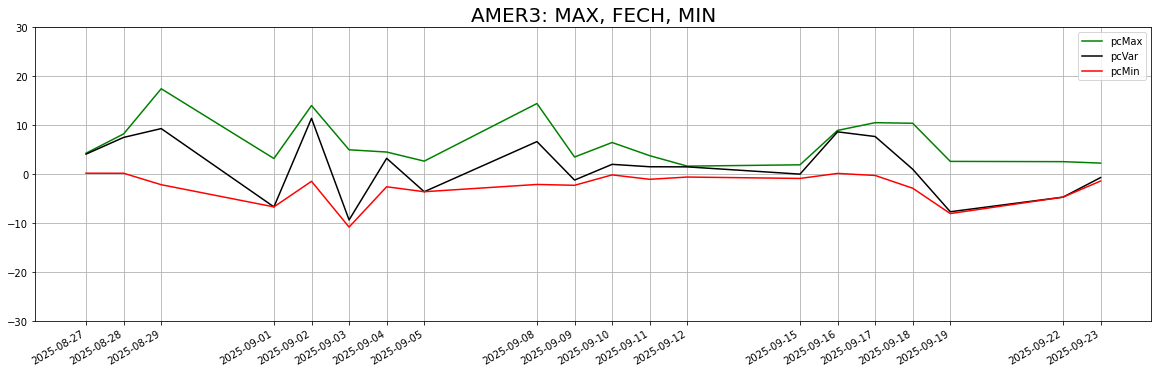

AMER3


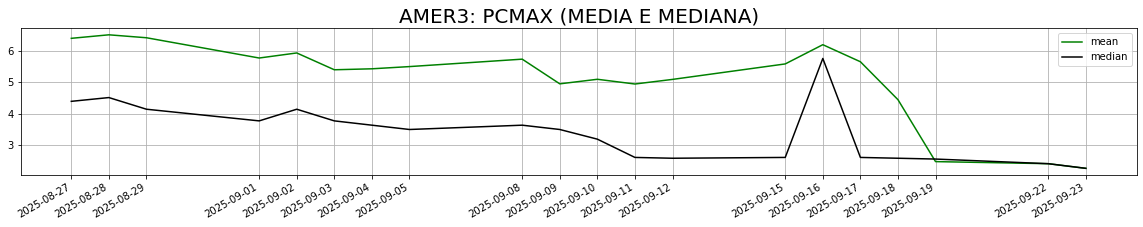

In [21]:
%run graficos_acao.ipynb
# FileLink('graficos_acao.ipynb')

In [22]:
printmd(f'**<div style="color:white; background-color: green; font-size: 15pt; padding: 5px 0px 5px 10px; font-weight: bold">Botões para melhores ações de {acao_botoes}</div>**')

**<div style="color:white; background-color: green; font-size: 15pt; padding: 5px 0px 5px 10px; font-weight: bold">Botões para melhores ações de d15</div>**

In [23]:
buttons = widgets.HBox(lista_buttons)
widgets.VBox([buttons, output])

<p style="color:white; background-color: #F4750C; font-size: 15pt; padding: 5px 0px 5px 10px; font-weight: bold">  Ações presentes em todos os períodos </p>

In [24]:
merge_final

,Acao
0,PCAR3
1,AMER3


<p style="color:white; background-color: #F4750C; font-size: 15pt; padding: 5px 0px 5px 10px; font-weight: bold">  Grandes Variações de Volume </p>

In [25]:
grandes_variacoes_volume(df)

,Acao,dtPregao_x,vrVolume_x,pcVar_x,vrFech_x,vrVolume_y,pcVar_y,vrFech_y,dtPregao_y
317,BRBI11,2025-09-22,"3,441,589.00",-1.39%,17.75,"24,072,394.00",11.27%,19.75,2025-09-23
290,BOVB11,2025-09-22,"1,044,944.39",-0.52%,148.01,"8,513,597.44",0.91%,149.35,2025-09-23
169,BBOV11,2025-09-22,"1,364,622.88",-0.24%,75.83,"12,312,891.98",0.62%,76.30,2025-09-23
1409,STBP3,2025-09-22,"33,570,501.00",0.00%,14.37,"205,138,741.00",0.14%,14.39,2025-09-23
855,ISEN11,2025-09-22,"1,646,687.72",0.08%,104.13,"15,284,152.18",0.07%,104.20,2025-09-23
1405,SPYI11,2025-09-22,"3,494,944.72",0.71%,112.29,"18,989,216.06",-1.55%,110.55,2025-09-23
1402,SPXI11,2025-09-22,"7,065,426.99",0.77%,390.25,"48,400,219.86",-1.60%,384.00,2025-09-23
1203,QQQI11,2025-09-22,"1,128,297.46",0.80%,101.30,"16,564,324.61",-1.63%,99.65,2025-09-23
1069,NFLX34,2025-09-22,"1,975,075.07",-0.24%,130.24,"11,209,250.24",-1.77%,127.94,2025-09-23
1443,TECK11,2025-09-22,"4,428,655.52",0.03%,113.90,"38,618,956.54",-2.05%,111.56,2025-09-23


<p style="color:white; background-color: #F4750C; font-size: 15pt; padding: 5px 0px 5px 10px; font-weight: bold">   </p>

IntProgress(value=0, layout=Layout(width='400px'), style=ProgressStyle(description_width='initial'))

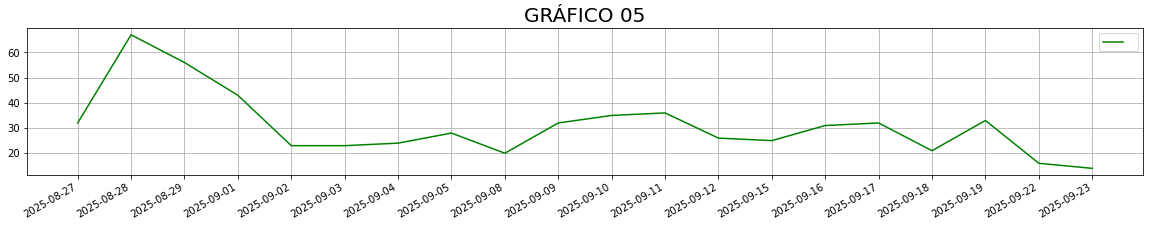

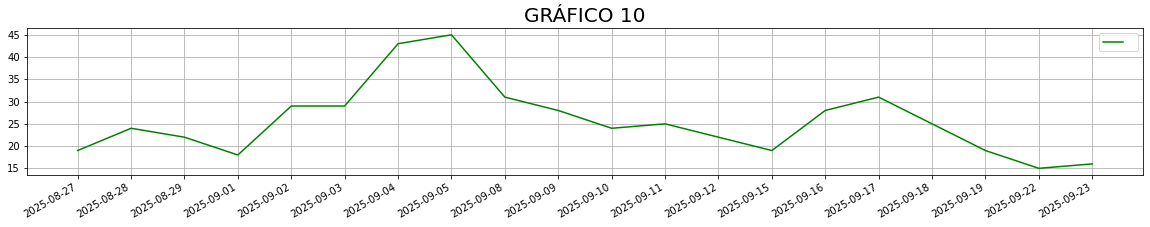

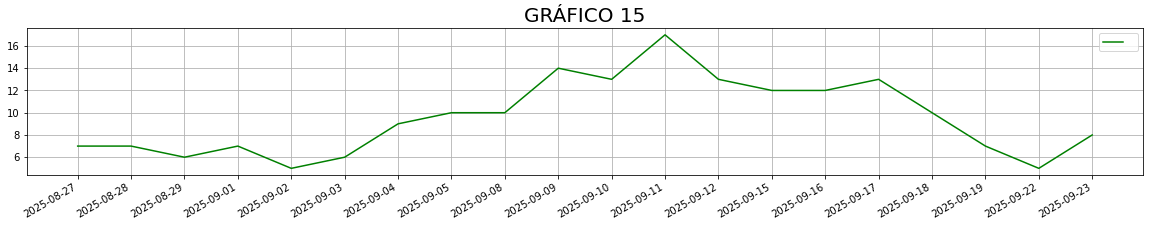

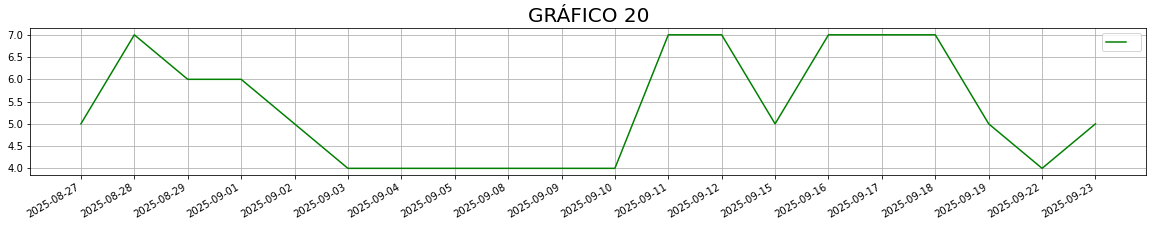

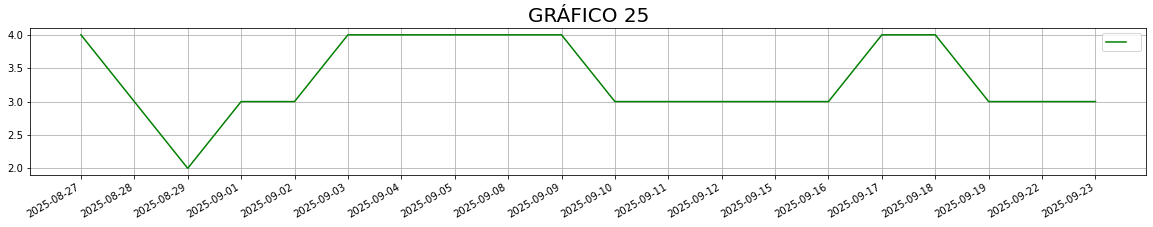

In [26]:
%run graficos_periodos.ipynb
# FileLink("graficos_periodos.ipynb")

In [27]:
bla

NameError: name 'bla' is not defined

In [ ]:
df.loc[(df["pcVar"] > 40) & (df["pcVar"] != df["pcMin"]) & (df["pcVar"] < 60) & (df["dtPregao"] != "2025-01-02")]

In [ ]:
# https://stackoverflow.com/questions/39450065/python-3-read-write-compressed-json-objects-from-to-gzip-file
import gzip
import json

def write_json_gzip(data, jsonfilename):                         # 1. data
    json_str = data.to_json(date_format='iso', orient='records') # 2. string (i.e. JSON)
    json_bytes = json_str.encode('utf-8')                        # 3. bytes (i.e. UTF-8)

    with gzip.open(jsonfilename, 'w') as fout:                   # 4. fewer bytes (i.e. gzip)
        fout.write(json_bytes)
        
def read_json_gzip(jsonfilename):
    with gzip.open(jsonfilename, 'r') as fin:        # 4. gzip
        json_bytes = fin.read()                      # 3. bytes (i.e. UTF-8)

    json_str = json_bytes.decode('utf-8')            # 2. string (i.e. JSON)
    df_json = pd.read_json(json_str)
    
    df_json['dtPregao'] = pd.to_datetime(df_json['dtPregao']).dt.strftime('%Y-%m-%d')

    return df_json

In [ ]:
jsonfilename = 'teste.json.gz'
# write_json_gzip(consulta_acao(df, acao_adhoc), jsonfilename)
write_json_gzip(df, jsonfilename)

In [ ]:
# read_json_gzip(jsonfilename)

In [ ]:
%run Resultados.ipynb

In [ ]:
dfFinal

In [ ]:
df_tot_mes_format